<a href="https://colab.research.google.com/github/IvyAldama/EstructurasDeDatos/blob/main/Completitud_y_PCA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# ------------------------------
# PASO 0: Importar librerías necesarias
# ------------------------------
import pandas as pd                       # Manejo de datos en tablas (DataFrame)
import numpy as np                        # Operaciones numéricas
import matplotlib.pyplot as plt           # Visualización básica
import seaborn as sns                     # Visualización avanzada

# Habilitar IterativeImputer porque es experimental
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, KNNImputer, SimpleImputer
from sklearn.preprocessing import StandardScaler  # Escalado de datos para PCA
from sklearn.decomposition import PCA             # Análisis de Componentes Principales

from google.colab import files
uploaded = files.upload()                 #Cargar CSV

Saving application_train.csv to application_train.csv


In [3]:
# ------------------------------
# PASO 1: Cargar el dataset
# ------------------------------
# Obtenemos el nombre del archivo
file_name = list(uploaded.keys())[0]
data = pd.read_csv(file_name)
print("Primeras filas del dataset:")
display(data.head())

Primeras filas del dataset:


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


Información general del dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Columns: 122 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(65), int64(41), object(16)
memory usage: 286.2+ MB
Columnas con valores faltantes (%):
COMMONAREA_MEDI             69.872297
COMMONAREA_MODE             69.872297
COMMONAREA_AVG              69.872297
NONLIVINGAPARTMENTS_MODE    69.432963
NONLIVINGAPARTMENTS_MEDI    69.432963
                              ...    
EXT_SOURCE_2                 0.214626
AMT_GOODS_PRICE              0.090403
AMT_ANNUITY                  0.003902
CNT_FAM_MEMBERS              0.000650
DAYS_LAST_PHONE_CHANGE       0.000325
Length: 67, dtype: float64


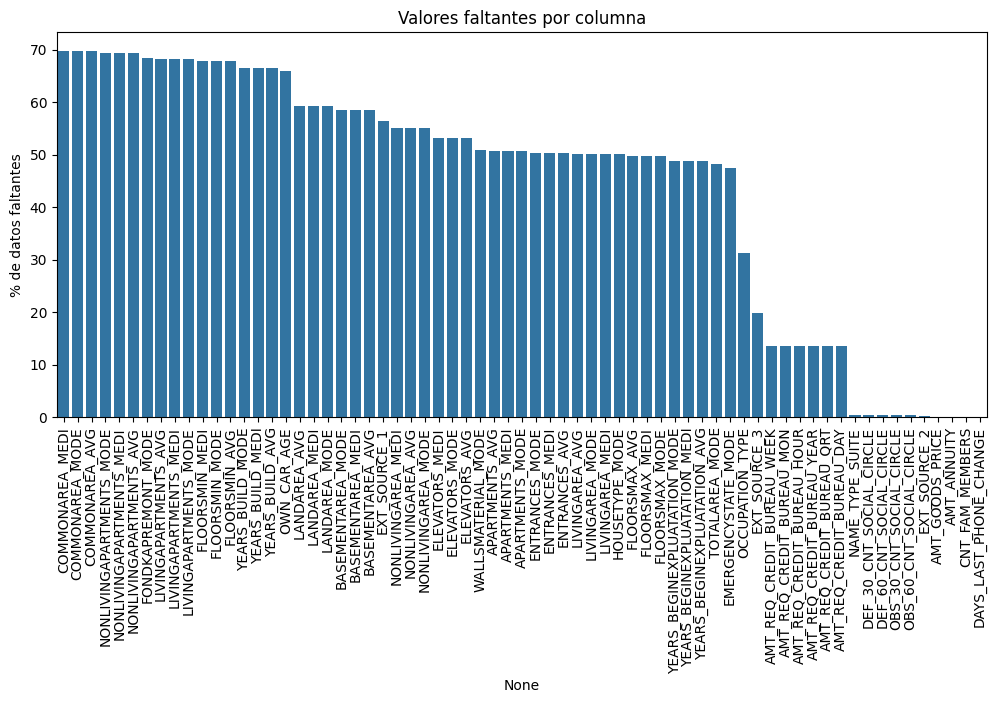

In [4]:
# ------------------------------
# PASO 2: Análisis exploratorio inicial
# ------------------------------
print("Información general del dataset:")
data.info()  # Tipos de datos y valores nulos

# Porcentaje de valores faltantes por columna
missing = data.isnull().mean() * 100
missing = missing[missing > 0].sort_values(ascending=False)
print("Columnas con valores faltantes (%):")
print(missing)

# Visualización de valores faltantes
plt.figure(figsize=(12,5))
sns.barplot(x=missing.index, y=missing.values)
plt.xticks(rotation=90)
plt.ylabel("% de datos faltantes")
plt.title("Valores faltantes por columna")
plt.show()


In [5]:
# ------------------------------
# PASO 3: Separar columnas numéricas y categóricas
# ------------------------------
num_cols = data.select_dtypes(include=[np.number]).columns
cat_cols = data.select_dtypes(include=['object']).columns


In [6]:
# ------------------------------
# PASO 4: Imputación de datos
# ------------------------------
# --- 4a: SimpleImputer como referencia ---
imputer_num = SimpleImputer(strategy='median')                      #SimpleImputer Como rellenador automatico
data[num_cols] = imputer_num.fit_transform(data[num_cols])

imputer_cat = SimpleImputer(strategy='most_frequent')
data[cat_cols] = imputer_cat.fit_transform(data[cat_cols])

print("Valores nulos después de imputación simple:", data.isnull().sum().sum())

# --- 4b: Imputación avanzada: KNN ---
knn_imputer = KNNImputer(n_neighbors=5)                           #para cada valor faltante buscará los 5 registros más cercanoy usará esos vecinos para estimar el valor faltante (por defecto se promedia)
data_knn = data.copy()
data_knn[num_cols] = knn_imputer.fit_transform(data_knn[num_cols]) #selecciona solo las columnas numericas
print("Imputación KNN aplicada a columnas numéricas.")

# --- 4c: Imputación avanzada: IterativeImputer ---
iter_imputer = IterativeImputer(max_iter=10, random_state=42)       #Crear un objeto IterativeImpute, max_iter=10 indica que el proceso iterará hasta 10 veces random_state=42 fija la semilla aleatoria
data_iter = data.copy()
data_iter[num_cols] = iter_imputer.fit_transform(data_iter[num_cols])#fit_transform aquí realiza la secuencia de regresiones iterativa, aplica solo a columnas numericas
print("Imputación iterativa aplicada a columnas numéricas.")


Valores nulos después de imputación simple: 0
Imputación KNN aplicada a columnas numéricas.
Imputación iterativa aplicada a columnas numéricas.


In [7]:
# ------------------------------
# PASO 5: One-hot encoding para variables categóricas
# ------------------------------
# Convertimos categóricas a columnas numéricas
data_encoded = pd.get_dummies(data_knn, drop_first=True)
print("Número de columnas después de one-hot encoding:", data_encoded.shape[1])

Número de columnas después de one-hot encoding: 230


In [8]:
# ------------------------------
# PASO 6: Escalado de datos
# ------------------------------
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data_encoded)

In [9]:
# ------------------------------
# PASO 7: PCA
# ------------------------------
# Mantener componentes que expliquen 95% de la varianza
pca = PCA(n_components=0.95)
data_pca = pca.fit_transform(data_scaled)
print("Número de componentes para 95% de varianza:", pca.n_components_)

Número de componentes para 95% de varianza: 162


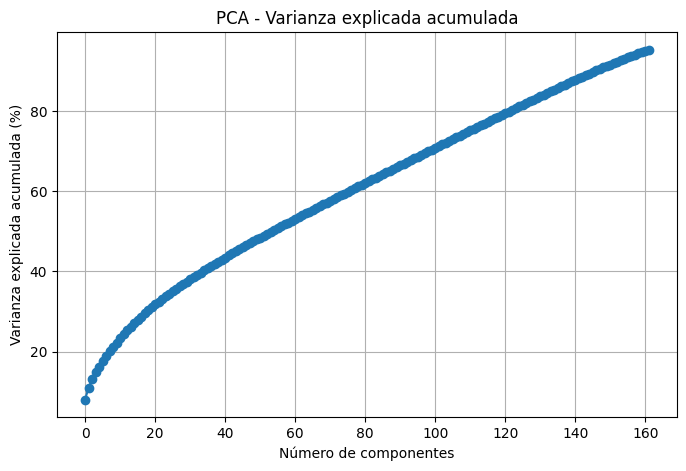

In [10]:
# ------------------------------
# PASO 8: Visualización de varianza explicada
# ------------------------------
plt.figure(figsize=(8,5))
plt.plot(np.cumsum(pca.explained_variance_ratio_)*100, marker='o')
plt.xlabel("Número de componentes")
plt.ylabel("Varianza explicada acumulada (%)")
plt.title("PCA - Varianza explicada acumulada")
plt.grid(True)
plt.show()

In [11]:
# ------------------------------
# PASO 9: Interpretación de los componentes principales
# ------------------------------
components = pd.DataFrame(pca.components_, columns=data_encoded.columns)

print("Top 10 variables que más influyen en el primer componente:")
print(components.iloc[0].abs().sort_values(ascending=False).head(10))

print("Top 10 variables que más influyen en el segundo componente:")
print(components.iloc[1].abs().sort_values(ascending=False).head(10))

Top 10 variables que más influyen en el primer componente:
LIVINGAREA_AVG     0.216429
LIVINGAREA_MEDI    0.216415
APARTMENTS_MEDI    0.215351
APARTMENTS_AVG     0.215264
LIVINGAREA_MODE    0.213014
TOTALAREA_MODE     0.212951
APARTMENTS_MODE    0.211810
ELEVATORS_AVG      0.203515
ELEVATORS_MEDI     0.203506
ELEVATORS_MODE     0.201904
Name: 0, dtype: float64
Top 10 variables que más influyen en el segundo componente:
ORGANIZATION_TYPE_XNA         0.357635
FLAG_EMP_PHONE                0.357599
NAME_INCOME_TYPE_Pensioner    0.357588
DAYS_EMPLOYED                 0.357137
DAYS_BIRTH                    0.274949
FLAG_DOCUMENT_6               0.245654
OCCUPATION_TYPE_Laborers      0.201737
NAME_INCOME_TYPE_Working      0.173817
REG_CITY_NOT_WORK_CITY        0.140971
CNT_FAM_MEMBERS               0.133643
Name: 1, dtype: float64



🔹 Método: SimpleImputer
   Número de componentes necesarios: 162
   Varianza explicada acumulada: 95.30%

🔹 Método: KNNImputer
   Número de componentes necesarios: 162
   Varianza explicada acumulada: 95.30%

🔹 Método: IterativeImputer
   Número de componentes necesarios: 162
   Varianza explicada acumulada: 95.30%


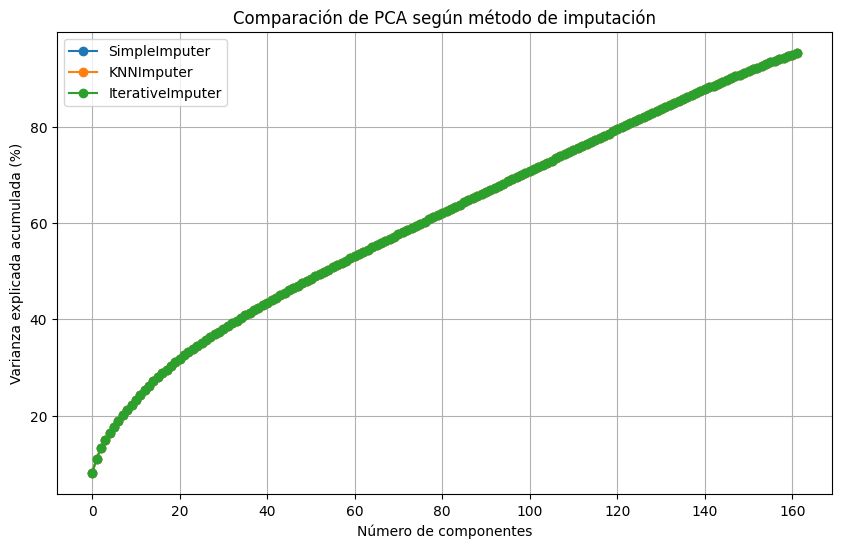

In [12]:
# ------------------------------
# PASO 10: Comparación de imputaciones
# ------------------------------

# 1. Definimos un diccionario con los datasets imputados
datasets_imputados = {
    "SimpleImputer": data,       # ya imputado con media/moda
    "KNNImputer": data_knn,      # imputado con vecinos más cercanos
    "IterativeImputer": data_iter # imputado de forma iterativa (regresión)
}

# 2. Función para aplicar PCA y devolver el % de varianza explicada acumulada
def aplicar_pca(dataset, nombre):
    # One-hot encoding para convertir categóricas a numéricas
    data_encoded = pd.get_dummies(dataset, drop_first=True)

    # Escalar datos
    scaler = StandardScaler()
    data_scaled = scaler.fit_transform(data_encoded)

    # Aplicar PCA manteniendo 95% de la varianza
    pca = PCA(n_components=0.95)
    data_pca = pca.fit_transform(data_scaled)

    print(f"\n🔹 Método: {nombre}")
    print(f"   Número de componentes necesarios: {pca.n_components_}")
    print(f"   Varianza explicada acumulada: {np.sum(pca.explained_variance_ratio_)*100:.2f}%")

    return pca

# 3. Ejecutamos PCA para cada método de imputación
pca_resultados = {}
for metodo, dataset in datasets_imputados.items():
    pca_resultados[metodo] = aplicar_pca(dataset, metodo)

# 4. Visualizamos comparación de varianza explicada
plt.figure(figsize=(10,6))
for metodo, pca in pca_resultados.items():
    plt.plot(np.cumsum(pca.explained_variance_ratio_)*100, marker='o', label=metodo)

plt.xlabel("Número de componentes")
plt.ylabel("Varianza explicada acumulada (%)")
plt.title("Comparación de PCA según método de imputación")
plt.legend()
plt.grid(True)
plt.show()

In [14]:
# ------------------------------
# PASO 11: Separación en entrenamiento y prueba
# ------------------------------
from sklearn.model_selection import train_test_split

# Variable objetivo
y = data['TARGET']

# Eliminamos la columna TARGET de los features
X = data_encoded.drop(columns=['TARGET'], errors='ignore')

# División en entrenamiento (80%) y prueba (20%)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Tamaño de entrenamiento:", X_train.shape)
print("Tamaño de prueba:", X_test.shape)
print("\nDistribución de la variable objetivo en Entrenamiento:")
print(y_train.value_counts(normalize=True))
print("\nDistribución de la variable objetivo en Prueba:")
print(y_test.value_counts(normalize=True))

Tamaño de entrenamiento: (246008, 229)
Tamaño de prueba: (61503, 229)

Distribución de la variable objetivo en Entrenamiento:
TARGET
0.0    0.919271
1.0    0.080729
Name: proportion, dtype: float64

Distribución de la variable objetivo en Prueba:
TARGET
0.0    0.919272
1.0    0.080728
Name: proportion, dtype: float64
